# PLN Proyecto Final: Análisis de sentimientos, usando modelos de NGramas y LLMs de HuggingFace con técnicas Zero-shot y Few-shot.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Descargando datos

In [1]:
!gdown 1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_

Downloading...
From (original): https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_
From (redirected): https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_&confirm=t&uuid=c3906096-52cd-4c7c-8353-ab6e0705e36f
To: /content/final-train.csv
100% 199M/199M [00:09<00:00, 21.9MB/s]


In [2]:
import pandas as pd

df = pd.read_csv('final-train.csv')
df

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5
...,...,...,...
426335,funnel cake mix,This is very good and just like the gourmet on...,4
426336,Yummy Fruit Snacks,I bought these for my kids but find myself eat...,5
426337,Great coffee,eight oclock makes great coffee and with balan...,5
426338,Earl Grey of Earl Grey +++,I already liked regular Stash Earl Grey and so...,5


In [3]:
df.value_counts('Score')

,count
Score,
5,272086
4,60490
1,39385
3,31972
2,22407


In [4]:
df = df[df['Score'].isin([1,2,5])]

In [5]:
df['Score'] = df['Score'].apply(lambda x: 1 if x < 3 else 0)

<ipython-input-5-04827aebd9d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Score'] = df['Score'].apply(lambda x: 1 if x < 3 else 0)


Se reclasifican los Scores en base a la siguiente regla:

* Clase 1 (Negativo) = Score 1 y 2
* Clase 0 (Positivo) = Scores 5

In [6]:
df['Score'].value_counts()

,count
Score,
0,272086
1,61792


Se toma una muestra más pequeña del conjunto de datos y se hace un balanceo de clases, ya que sólo el 14% del dataset corresponde a la clase negativa (1,2) y el 86% del dataset corresponde a clases no negativas (3,4,5)

In [7]:
def generar_muestra(df):
  # Fracción para la muestra total
  frac_total = 0.2

  # Proporciones aproximadas para negativos y no negativos
  neg_frac = 0.51  # 55% negativos
  non_neg_frac = 0.49  # 45% no negativos (0 en la columna Negative)

  # Dividiendo el dataset en negativos (1) y no negativos (0)
  negativos = df[df['Score'] == 1]
  no_negativos = df[df['Score'] == 0]

  # Calculando el tamaño total de la muestra
  sample_size = int(len(df) * frac_total)

  # Calculando el tamaño de las muestras para negativos y no negativos
  neg_sample_size = int(sample_size * neg_frac)
  non_neg_sample_size = int(sample_size * non_neg_frac)

  # Tomando muestras de cada clase
  neg_sample = negativos.sample(n=neg_sample_size, random_state=42)
  non_neg_sample = no_negativos.sample(n=non_neg_sample_size, random_state=42)

  # Combinando las muestras
  balanced_sample = pd.concat([neg_sample, non_neg_sample])

  # Barajareamos la muestra combinada (opcional, aqui lo incluimos)
  balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

  return balanced_sample

df_sample = generar_muestra(df)

# Resultado: Verificando el balance de la muestra
print("Distribución de la muestra balanceada:")
print(df_sample['Score'].value_counts())

# Resultado final
df_sample.head()

Distribución de la muestra balanceada:
Score
1    34055
0    32719
Name: count, dtype: int64


,Summary,Text,Score
0,Yuck! I love hot chocolate but this is sickeni...,A coworker of mine asked me to purchase this f...,1
1,Excellent product,If you're used to fruit loops or even cheerios...,0
2,Terrible smell,The last two packages I purchased had a terrib...,1
3,Cheaper Price - But Popcorn Older and Stale,Pop Secret is by far my favorite popcorn and I...,1
4,Sweet not Sour,"These lemon drops have a good taste. However, ...",1


Se crean los conjuntos de entrenamiento y validación

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = df_sample['Score'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_sample['Text'].values, y, test_size=0.2, random_state=642, stratify=y)
print(f"Training set size: {len(X_train_raw)}")
print(f"Test set size: {len(X_test_raw)}")

Training set size: 53419
Test set size: 13355


## Limpieza y Preprocesamiento

In [9]:
import nltk
from nltk import word_tokenize
import re
from string import punctuation
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.discard('not')
stop_words.discard('no')
stop_words.discard('we')
stop_words.discard('you')
stop_words.discard('i')
stop_words.discard('he')
stop_words.discard('she')
stop_words.discard('they')
stop_words.discard('there')
stop_words.discard('our')
stop_words.discard('us')
stop_words.discard('my')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
from bs4 import BeautifulSoup

def clean_text(text):

    text = text.lower()

    # Eliminar espacios antes de signos de puntuación
    text = re.sub(r'\s+([.,!?;:])', r'\1', text)

    # Eliminando todas las comillas dobles
    text = text.replace('"', '')

    # Eliminando etiquetas HTML completas, incluyendo <a> y su contenido
    text = re.sub(r'<a.*?>.*?</a>', '', text, flags=re.DOTALL)

    # Eliminando etiquetas HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Eliminando URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Eliminando diagonales invertidas que preceden a apóstrofes o comillas escapadas
    text = re.sub(r"\\(['\"])", r'\1', text)

    # Eliminando caracteres de escape como \n, \t, y diagonales inversas (\)
    text = re.sub(r'\\', '', text)

    # Eliminando cualquier otro patrón que quieras limpiar
    text = re.sub(r'\s+', ' ', text)  # Asegurar que no haya espacios repetidos

    return text.strip()

# Funcion que se va utilizar para preprocesado de los datos
def preprocess_data(raw_data):
    raw_data = [clean_text(doc) for doc in raw_data]
    tokenized_docs = [[word for word in word_tokenize(doc) if word not in stop_words] for doc in raw_data]
    processed_docs = [' '.join(doc) for doc in tokenized_docs]
    processed_docs = [re.sub(r'\s+([.,!?;:\'])', r'\1', doc) for doc in processed_docs]
    return processed_docs

In [11]:
train_docs = preprocess_data(X_train_raw)
test_docs = preprocess_data(X_test_raw)

<ipython-input-10-30e9a0f42372>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [12]:
train_docs[0]

'we use seeds sparingly grow sprouts use sandwiches, salads, etc. easy grow, variety seeds adds punch flavors. i highly recommend product ease use taste.'

###TF-IDF

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = CountVectorizer(max_features=2000,stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_docs)
X_test_tfidf = tfidf_vectorizer.transform(test_docs)

## Naive-bayes

{'alpha': 34.7004081632653}
Accuracy: 0.8625233994758518
F1-score: 0.8623688155922039
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6544
           1       0.88      0.84      0.86      6811

    accuracy                           0.86     13355
   macro avg       0.86      0.86      0.86     13355
weighted avg       0.86      0.86      0.86     13355



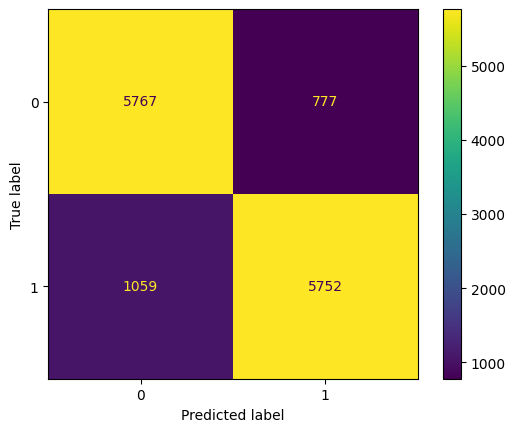

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Búqueda de parámetros
param_grid = {
    'alpha': np.linspace(0.01, 100)
}


nb = MultinomialNB()

rs = RandomizedSearchCV(estimator=nb, param_distributions=param_grid, n_iter=10, cv=5, scoring='f1', n_jobs=-1)
rs.fit(X_train_tfidf, y_train)

print(rs.best_params_)

nb_best_model = rs.best_estimator_
nb_best_model.fit(X_train_tfidf, y_train)

y_pred = nb_best_model.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Regresión logística

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1204, in fit
    raise ValueError("l1_ratio must be specified when penalty is elasticnet.

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 91.83755102040817}
Accuracy: 0.8819917633845001
F1-score: 0.8841517200823287
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6544
           1       0.89      0.88      0.88      6811

    accuracy                           0.88     13355
   macro avg       0.88      0.88      0.88     13355
weighted avg       0.88      0.88      0.88     13355



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


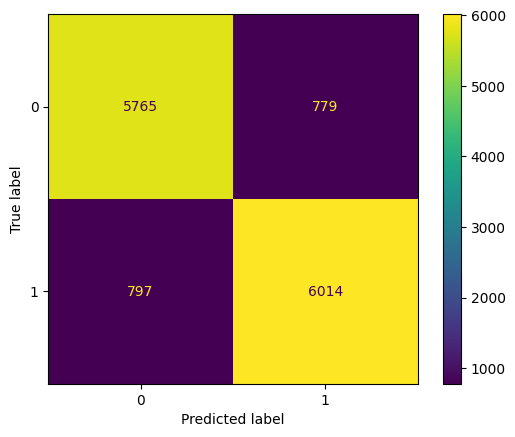

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

# Búqueda de parámetros
param_grid = {
    'C': np.linspace(0.01, 100),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': np.arange(100, 300, 100)
}


lr = LogisticRegression()

rs = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, n_iter=10, cv=5, scoring='f1', n_jobs=-1)
rs.fit(X_train_tfidf, y_train)

print(rs.best_params_)

lr_best_model = rs.best_estimator_
lr_best_model.fit(X_train_tfidf, y_train)

y_pred = lr_best_model.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Modelos LLM preentrenados de HuggingFace

### Sampleo

In [17]:
num_training_docs = 300
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(test_docs, y_test,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_test)

In [18]:
len(sample_train_docs)

300

In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
#model_name = "Qwen/Qwen2.5-Coder-7B-Instruct"
#model_name = "mosaicml/mpt-7b"
#model_name = "tiiuae/falcon-7b-instruct"
#model_name = "microsoft/Phi-3.5-mini-instruct"
#model_name = "HuggingFaceH4/zephyr-7b-beta"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

### Sentiment Analysis

#### Zero-shot

In [20]:
responses = []

for k,sentence in enumerate(sample_train_docs):
    prompt = "Text: " + sentence
    messages = [
        {"role": "system", "content": "You are a helpful assistant performing binary sentiment analysis. Respond only 'positive' or 'negative'."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=16
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"{k+1}/{len(sample_train_docs)} done")
    responses.append(response)

print(responses)

1/300 done
2/300 done
3/300 done
4/300 done
5/300 done
6/300 done
7/300 done
8/300 done
9/300 done
10/300 done
11/300 done
12/300 done
13/300 done
14/300 done
15/300 done
16/300 done
17/300 done
18/300 done
19/300 done
20/300 done
21/300 done
22/300 done
23/300 done
24/300 done
25/300 done
26/300 done
27/300 done
28/300 done
29/300 done
30/300 done
31/300 done
32/300 done
33/300 done
34/300 done
35/300 done
36/300 done
37/300 done
38/300 done
39/300 done
40/300 done
41/300 done
42/300 done
43/300 done
44/300 done
45/300 done
46/300 done
47/300 done
48/300 done
49/300 done
50/300 done
51/300 done
52/300 done
53/300 done
54/300 done
55/300 done
56/300 done
57/300 done
58/300 done
59/300 done
60/300 done
61/300 done
62/300 done
63/300 done
64/300 done
65/300 done
66/300 done
67/300 done
68/300 done
69/300 done
70/300 done
71/300 done
72/300 done
73/300 done
74/300 done
75/300 done
76/300 done
77/300 done
78/300 done
79/300 done
80/300 done
81/300 done
82/300 done
83/300 done
84/300 done
8

In [21]:
# Codifica "positive" -> 0, "negative" -> 1
def encode(x):
    if x.lower() == "positive":
        return 0
    else:
        return 1

Accuracy: 0.9533333333333334
F1-score: 0.9536423841059603
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       147
           1       0.97      0.94      0.95       153

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



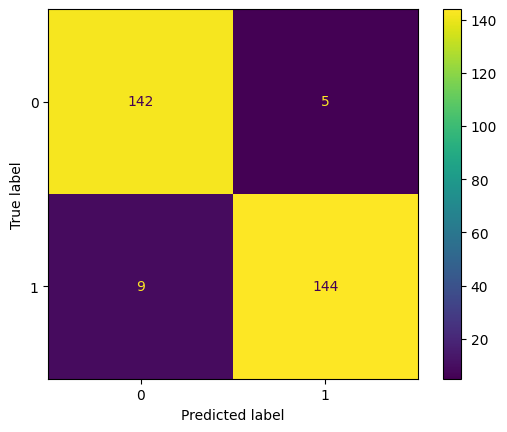

In [22]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = [encode(x) for x in responses]

print(f"Accuracy: {accuracy_score(sample_train_labels, y_pred)}")
print(f"F1-score: {f1_score(sample_train_labels, y_pred)}")

print(classification_report(sample_train_labels, y_pred))

cm = confusion_matrix(sample_train_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=["negative", "positive"])
disp.plot()

#### Few-shot

In [97]:
sample_docs = sample_val_docs[:300].copy()
sample_labels = sample_val_labels[:300].copy()


In [98]:
print(len(sample_docs))
print(sample_docs)
print(sample_labels)

300
["i ordered boxes i could n't stomach. spices type dish, point made could n't stand taste. way much cinnamon. i ended throwning my boxes. i would recommend kohinoor brand day.", "hands best formula market. sadly, my breast milk dried i fine formula. my poor son many gi, stomach, gas, crying, reflux, etc issues. we alimentum month. we even tried ready eat b/c i heard corn free. i also tried hypoallergenic version enfamel. nothing made better.after researching dha/ara... i found scary things. basically, made using chemicals. there babies horrible reaction b/c toxins. you google. anyway, i found organic formula n't ( you buy dha/ara seperate made eggs organically no chemicals ). i nervous... b/c my son many issues... i n't want make worse. i tried! seriously, changed my son's life! he completely different baby! i no longer even give acid reflux meds anymore... i mean course still there... much better. my son since he 6 weeks. i know says toddler, you go site fda approved infants. they

In [99]:
import numpy as np
np.unique(sample_labels, return_counts=True)

(array([0, 1]), array([138, 162]))

In [100]:
import random

In [101]:
responses = []

label_to_text = {1: "negative", 0: "positive"}

for k,sentence in enumerate(sample_docs):
    prompt = ""
    # Obtener los índices para los dos elementos restantes
    #idxs = [i for i in range(len(sample_docs)) if i != k][:2]  # Excluir k y tomar 2 elementos
    idxs = random.sample([i for i in range(len(sample_docs)) if i != k], 2)
    # Iterar solo sobre los dos elementos seleccionados
    for idx in idxs:
        label = sample_labels[idx]
        text = sample_docs[idx]
        prompt += f"\n{text} // {label_to_text[label]}\n"
    prompt += f"\n{sentence} // "
    #print(prompt)
    #break
    messages = [
        {"role": "system", "content": "You are a helpful assistant performing binary sentiment analysis. Respond only 'negative' or 'positive'."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=16
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"{k+1}/{len(sample_docs)} done")
    responses.append(response)

print(responses)



1/300 done
2/300 done
3/300 done
4/300 done
5/300 done
6/300 done
7/300 done
8/300 done
9/300 done
10/300 done
11/300 done
12/300 done
13/300 done
14/300 done
15/300 done
16/300 done
17/300 done
18/300 done
19/300 done
20/300 done
21/300 done
22/300 done
23/300 done
24/300 done
25/300 done
26/300 done
27/300 done
28/300 done
29/300 done
30/300 done
31/300 done
32/300 done
33/300 done
34/300 done
35/300 done
36/300 done
37/300 done
38/300 done
39/300 done
40/300 done
41/300 done
42/300 done
43/300 done
44/300 done
45/300 done
46/300 done
47/300 done
48/300 done
49/300 done
50/300 done
51/300 done
52/300 done
53/300 done
54/300 done
55/300 done
56/300 done
57/300 done
58/300 done
59/300 done
60/300 done
61/300 done
62/300 done
63/300 done
64/300 done
65/300 done
66/300 done
67/300 done
68/300 done
69/300 done
70/300 done
71/300 done
72/300 done
73/300 done
74/300 done
75/300 done
76/300 done
77/300 done
78/300 done
79/300 done
80/300 done
81/300 done
82/300 done
83/300 done
84/300 done
8

In [102]:
y_pred = [encode(x) for x in responses]

Accuracy: 0.6833333333333333
F1-score: 0.7710843373493976
              precision    recall  f1-score   support

           0       0.96      0.33      0.49       138
           1       0.63      0.99      0.77       162

    accuracy                           0.68       300
   macro avg       0.79      0.66      0.63       300
weighted avg       0.78      0.68      0.64       300



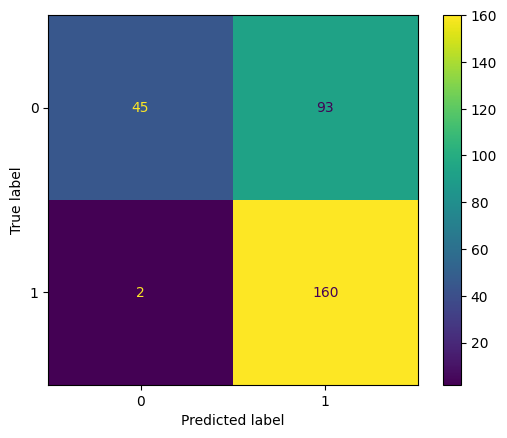

In [103]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f"Accuracy: {accuracy_score(sample_labels, y_pred)}")
print(f"F1-score: {f1_score(sample_labels, y_pred)}")

print(classification_report(sample_labels, y_pred))


cm = confusion_matrix(sample_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=["negative", "positive"])
disp.plot()

## Resultados

#### Modelos de NGramas

* (A.1) Naive-Bayes + Quitando stopwords + Sin Balanceo = Acc 0.90, F1 0.72
* (A.2) Naive-Bayes + Quitando stopwords + Balanceo = Acc 0.86, F1 0.86

* (A.3) Logistic Regression + Quitando stopwords + Sin Balanceo = Acc: 0.92, F1: 0.76
* **(A.4) Logistic Regression + Quitando stopwords + Balanceo = Acc: 0.88, F1: 0.88**

Dado que en este caso nos interesa clasificar correctamente la clase negativa, el modelo (A.4) sería el mejor.


#### Modelos LLM preentrenados de HuggingFace

Zero-shot
* (B.1) Qwen 5B + Zero-shot + Quitando stopwords + Sin balanceo = Acc:0.83, F1: 0.65
* **(B.2) Qwen 5B + Zero-shot + Quitando stopwords + Con balanceo = Acc:0.95, F1:0.95**
* (B.3) Qwen 7B + Zero-shot + Quitando stopwords + Con balanceo = Acc:0.95, F1:0.95

* (B.4) Phi + Zero-shot + Quitando stopwords + Sin balanceo = Acc: 0.77, F1: 0.58
* (B.5) Phi + Zero-shot + Quitando stopwords + Con balanceo = Acc: 0.94 , F1: 0.94  


Few-shot
* (B.5) Qwen + Quitando stopwords + Sin balanceo= Acc: 0.6,  F1: 0.45
* (B.6) Qwen + Quitando stopwords + Con balanceo= Acc:0.68 ,  F1: 0.77

Dado que en este caso nos interes clasificar correctamente la clase negativa, el modelo (B.2) sería el mejor.

## Evaluación con conjunto el de pruebas test.csv

Carga de datos de prueba

In [23]:
df_test = pd.read_csv('test.csv')
df_test

,Summary,Text
0,I love Hills!,"My cat is picky, especially when it comes to d..."
1,"Thank you, Amazon!","My mom, who has always believed that breakfast..."
2,"Good product, good price",This is my third container of this drink mix. ...
3,Soooo Good!,The first time I had a cup of this tea was at ...
4,Not as good as Libby's; cans in bad condition,There have been ongoing problems with dented a...
...,...,...
7100,5Hour Energy-grape 2x12pk,I'm happy. Great price for the product I rely ...
7101,Excellent Product,I recommend this product & timliness of the de...
7102,Best organic shredded wheat squares with touch...,Best organic shredded wheat squares. Love the ...
7103,five star product,"Very good product, my wife drinks it all the t..."


Aplicando misma limpieza y preprocesamiento que en el entrenamiento

In [25]:
X_test = df_test['Text'].values
test_docs = preprocess_data(X_test)

<ipython-input-10-30e9a0f42372>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [30]:
X_test_tfidf = tfidf_vectorizer.transform(test_docs)

Realizamos la predicción sobre los modelos entrenados y guardamos el resultado en archivos CSV:

In [ ]:
# Naive-bayes
nb_y_pred = nb_best_model.predict(X_test_tfidf)
np.savetxt("/content/drive/MyDrive/PLN/clasificación_nb.csv", nb_y_pred, delimiter=",", fmt='%d')

In [ ]:
# Regresión logística
lr_y_pred = lr_best_model.predict(X_test_tfidf)
np.savetxt("/content/drive/MyDrive/PLN/clasificación_lr.csv", lr_y_pred, delimiter=",", fmt='%d')

In [31]:
# LLM "Qwen/Qwen2.5-1.5B-Instruct" Zero-shot
responses = []

for k,sentence in enumerate(test_docs):
    prompt = "Text: " + sentence
    messages = [
        {"role": "system", "content": "You are a helpful assistant performing binary sentiment analysis. Respond only 'positive' or 'negative'."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=16
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"{k+1}/{len(test_docs)} done")
    responses.append(response)

print(responses)

llm_y_pred = [encode(x) for x in responses]
np.savetxt("/content/drive/MyDrive/PLN/clasificación_llm.csv", y_pred, delimiter=",", fmt='%d')

Se truncaron las últimas líneas 5000 del resultado de transmisión.
2107/7105 done
2108/7105 done
2109/7105 done
2110/7105 done
2111/7105 done
2112/7105 done
2113/7105 done
2114/7105 done
2115/7105 done
2116/7105 done
2117/7105 done
2118/7105 done
2119/7105 done
2120/7105 done
2121/7105 done
2122/7105 done
2123/7105 done
2124/7105 done
2125/7105 done
2126/7105 done
2127/7105 done
2128/7105 done
2129/7105 done
2130/7105 done
2131/7105 done
2132/7105 done
2133/7105 done
2134/7105 done
2135/7105 done
2136/7105 done
2137/7105 done
2138/7105 done
2139/7105 done
2140/7105 done
2141/7105 done
2142/7105 done
2143/7105 done
2144/7105 done
2145/7105 done
2146/7105 done
2147/7105 done
2148/7105 done
2149/7105 done
2150/7105 done
2151/7105 done
2152/7105 done
2153/7105 done
2154/7105 done
2155/7105 done
2156/7105 done
2157/7105 done
2158/7105 done
2159/7105 done
2160/7105 done
2161/7105 done
2162/7105 done
2163/7105 done
2164/7105 done
2165/7105 done
2166/7105 done
2167/7105 done
2168/7105 done
216